In [1]:
#1.
import pandas as pd
from statsmodels.tsa.stattools import adfuller
data = pd.read_csv("C:/Users/user/OneDrive/文件/時間序列/Dataset-ARIMA.txt" ,encoding="utf-8",header=None , names=["Volatility"])
data

,Volatility
0,3.0692
1,6.7121
2,0.5711
3,2.1220
4,14.5181
...,...
335,3.0946
336,2.5901
337,1.1785
338,3.0513


In [2]:
#1. (a)

#我們使用Dickey-Fuller test
# H0: 此時間序列有單根
# HA: 此時間序列沒有單根

# Perform Augmented Dickey-Fuller Test
result = adfuller(data["Volatility"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"{key}: {value}")

if result[1] < 0.05:
    print("Reject the null hypothesis: The data does not have a unit root (is stationary)")
else:
    print("Fail to reject the null hypothesis: The data has a unit root (is non-stationary)")
    
#P-VALUE < 0.05  拒絕虛無
#且-5.885 < -3.45  所以在1%、5%顯著水準下，我們無法統計上說明此時間序列有單根

ADF Statistic: -5.885093690297449
p-value: 3.014655048107091e-07
Reject the null hypothesis: The data does not have a unit root (is stationary)


Optimal (p, q) values: 1 1


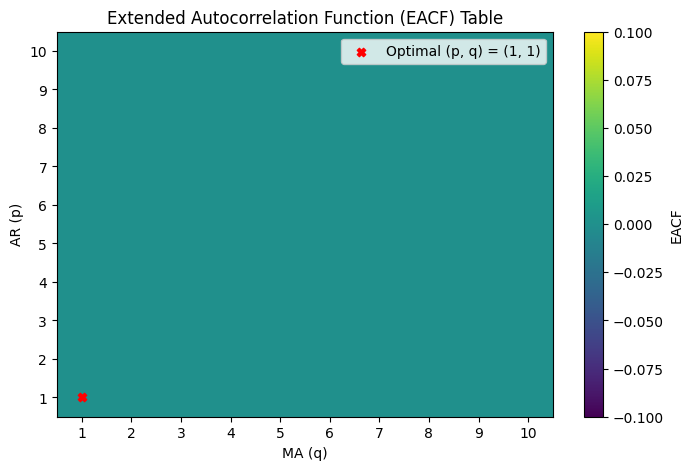

In [9]:
#1. (b)

#根據上一小題檢定結果  此序列沒有單根 所以i是0
#在ARMA中我們使用EACF方法來判斷 p、q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from itertools import product

data = pd.read_csv("C:/Users/user/OneDrive/文件/時間序列/Dataset-ARIMA.txt", header=None, names=["Volatility"])

# Define function to compute EACF
def eacf(data, max_p, max_q):
    eacf_table = np.zeros((max_p, max_q))
    for p in range(1, max_p + 1):
        for q in range(1, max_q + 1):
            try:
                _, acf_confint = acf(data, nlags=max(p, q), alpha=0.05)
                _, pacf_confint = pacf(data, nlags=max(p, q), alpha=0.05)
                acf_trunc = np.sum(acf_confint[:, 0] <= acf_confint[:, 1]) <= p
                pacf_trunc = np.sum(pacf_confint[:, 0] <= pacf_confint[:, 1]) <= q
                eacf_table[p - 1, q - 1] = int(acf_trunc and pacf_trunc)
            except:
                eacf_table[p - 1, q - 1] = np.nan
    return eacf_table

# Compute EACF
max_p = 10
max_q = 10
eacf_table = eacf(data["Volatility"], max_p, max_q)

# Find optimal (p, q) values
optimal_pq = np.unravel_index(np.argmax(eacf_table), eacf_table.shape)
optimal_p = optimal_pq[0] + 1
optimal_q = optimal_pq[1] + 1

print("Optimal (p, q) values:", optimal_p, optimal_q)

# Plot EACF table
plt.figure(figsize=(8, 5))
plt.imshow(eacf_table, cmap='viridis', origin='lower', aspect='auto')
plt.colorbar(label='EACF')
plt.xlabel('MA (q)')
plt.ylabel('AR (p)')
plt.title('Extended Autocorrelation Function (EACF) Table')
plt.xticks(np.arange(max_q), np.arange(1, max_q + 1))
plt.yticks(np.arange(max_p), np.arange(1, max_p + 1))
plt.scatter(optimal_q - 1, optimal_p - 1, marker='X', color='red', label=f'Optimal (p, q) = ({optimal_p}, {optimal_q})')
plt.legend()
plt.grid(False)
plt.show()

#所以最佳的p、i、q 為  1、0、1

In [5]:
#1.(c)

import statsmodels.api as sm

# 确定 ARIMA 模型的参数 (p, d, q)
p = 1
d = 0  # 已知为0
q = 1

# 创建 ARIMA 模型
model = sm.tsa.ARIMA(data, order=(p, d, q))

# 拟合 ARIMA 模型
results = model.fit()

# 打印模型系数
print("ARIMA 模型的系数：")
print(results.params)

# 打印系数的显著性
print("\n系数的显著性：")
print(results.pvalues)

#P VALUE都<0.05 非常顯著

ARIMA 模型的系数：
const     2.925581
ar.L1     0.934105
ma.L1    -0.854707
sigma2    5.123029
dtype: float64

系数的显著性：
const      1.560857e-13
ar.L1      1.649494e-45
ma.L1      1.613410e-16
sigma2    1.345986e-271
dtype: float64


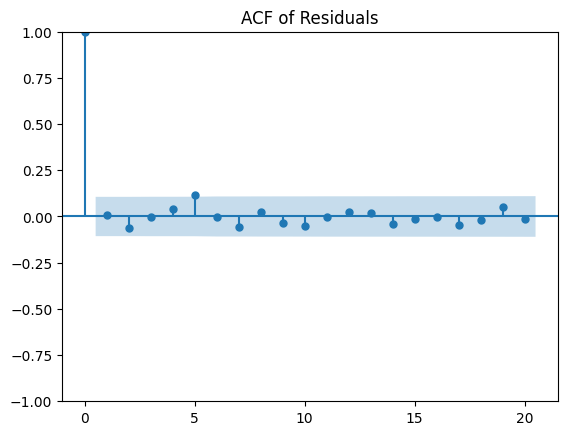

In [6]:
#1. (d)
#我們可以看ACF圖來判斷殘差是否為白噪音
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf

# 确定 ARIMA 模型的参数 (p, d, q)
p = 1
d = 0  # 已知为0
q = 1

# 创建 ARIMA 模型
model = ARIMA(data, order=(p, d, q))

# 拟合 ARIMA 模型
results = model.fit()

# 计算残差
residuals = results.resid

# 绘制残差的自相关函数（ACF）
plot_acf(residuals, lags=20)
plt.title('ACF of Residuals')
plt.show()

#由ACF圖，　幾乎ＡＣＦ都接近０　所以此序列是白噪音序列

Forecast for step 1: 3.409046099334354
Forecast for step 2: 3.377188176380184
Forecast for step 3: 3.3474295287815545
Forecast for step 4: 3.319631824952168
Forecast for step 5: 3.2936658486548493


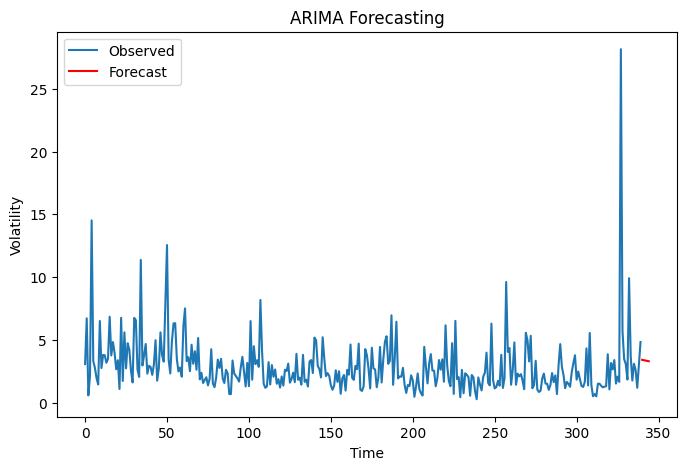

In [8]:
#1. (e)
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Fit the ARIMA model
model = ARIMA(data, order=(1, 0, 1))
fit_model = model.fit()

# Forecasting for k = 1 to 5
forecast_steps = 5
forecast = fit_model.forecast(steps=forecast_steps)

# Convert forecast to a Series with appropriate index
forecast_series = pd.Series(forecast, index=np.arange(len(data), len(data) + forecast_steps))

# Print the forecasting results
for k in range(1, forecast_steps + 1):
    print(f"Forecast for step {k}: {forecast_series.iloc[k - 1]}")

# Plotting the forecasts
plt.figure(figsize=(8, 5))
plt.plot(data, label='Observed')
plt.plot(forecast_series, color='red', label='Forecast')
plt.title('ARIMA Forecasting')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()